In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
from torch.distributions import MultivariateNormal, Categorical
set_seed(0)



0

In [2]:
class MO2G:
    def __init__(self):
        self.means = torch.tensor(
            [
                [-3.0,1],
                [3, -1],

            ]
        )
        self.covariances = torch.tensor(
            [
                [[1.0, 0], [0, 1.0]],
                [[1.0, 0], [0, 1.0]]

            ]
        )
        self.weights = torch.tensor([0.2,0.8])

        # Create a list of 2D Gaussian distributions
        self.gaussians = [
            MultivariateNormal(mean, covariance)
            for mean, covariance in zip(self.means, self.covariances)
        ]

    def sample(self, sample_shape):
        if isinstance(sample_shape, int):
            sample_shape = (sample_shape,)
        # Sample from the mixture
        categorical = Categorical(self.weights)
        sample_indices = categorical.sample(sample_shape)
        return torch.stack([self.gaussians[i].sample() for i in sample_indices])

    def log_prob(self, input):
        probs = torch.stack([g.log_prob(input).exp() for g in self.gaussians])
        probs = probs.T * self.weights
        return torch.sum(probs, dim=1).log()



In [3]:
#Base distribution
from torch.distributions.multivariate_normal import MultivariateNormal
toy_data = get_distribution("toy_2d")
MOG = toy_data()
MOG = MO2G()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_107960/39751654.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [4]:
plt.style.use("../../matplotlibrc")


In [5]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self._row_ix, self._column_ix = torch.tril_indices(dim,dim)
        # init_diag = torch.eye(dim)[self._row_ix, self._column_ix]
        init_diag = torch.ones(dim*(dim+1)//2)
        self.lower_triangular = nn.Parameter(init_diag.clone())
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample

    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))

    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))

    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov

    def log_prob(self, value):
        return MultivariateNormal(loc=self.mean, scale_tril=self.cov_lt()).log_prob(value)


In [6]:
10/1.77

5.649717514124294

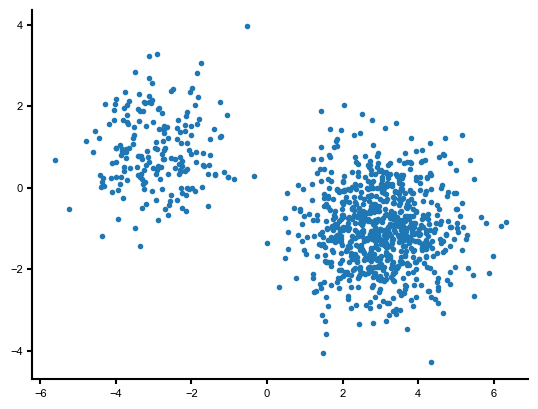

In [7]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")
covar = torch.cov(mixture_samples.T)
#plt.gca().set_box_aspect(1)


#make axis square

#plt.xlim()

In [8]:
def c2st_target(samples1, samples2, density1, density2):
    r"""Computes optimal C2ST and resulting classification cross-entropy loss
    for optimization
    """
    density_ratios1 = torch.stack([density1.log_prob(samples1), density2.log_prob(samples1)], dim=-1)
    density_ratios2 = torch.stack([density1.log_prob(samples2), density2.log_prob(samples2)], dim=-1)
    probs = torch.cat([density_ratios1, density_ratios2], dim=0)
    labels = torch.cat([torch.zeros(len(samples1)), torch.ones(len(samples2))], dim=0).long()
    loss = -nn.functional.cross_entropy(probs, labels)
    with torch.no_grad():
        c2st = (sum(density_ratios1[:, 0] >= density_ratios1[:, 1]) + sum(density_ratios2[:, 0] < density_ratios2[:, 1])) / (len(samples1) + len(samples2))
    return loss, c2st

In [9]:
n_iters =500
num_samples = 10000
gauss_model_C2ST = Gauss(2)

model_toy_opt = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=0.01)

for epoch in range(n_iters):
    model_toy_opt.zero_grad()

    model_samples = gauss_model_C2ST.sample(num_samples)
    toy_samples = MOG.sample(num_samples)

    cent_loss, true_c2st = c2st_target(model_samples, toy_samples, gauss_model_C2ST, MOG)
    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 5 == 0:
        print("Iter: {}     loss: {}     c2st: {}".format(epoch, cent_loss.item(), true_c2st.item()))
    cent_loss.backward()
    model_toy_opt.step()

Iter: 0     loss: -0.08224739879369736     c2st: 0.9706500172615051


Iter: 5     loss: -0.10545195639133453     c2st: 0.9611499905586243
Iter: 10     loss: -0.12152279168367386     c2st: 0.95455002784729
Iter: 15     loss: -0.14192883670330048     c2st: 0.9445499777793884
Iter: 20     loss: -0.17288894951343536     c2st: 0.9326000213623047
Iter: 25     loss: -0.19721585512161255     c2st: 0.9206500053405762
Iter: 30     loss: -0.22355419397354126     c2st: 0.909500002861023
Iter: 35     loss: -0.2519991099834442     c2st: 0.8963500261306763
Iter: 40     loss: -0.27930524945259094     c2st: 0.8833000063896179
Iter: 45     loss: -0.31353577971458435     c2st: 0.864549994468689
Iter: 50     loss: -0.33012256026268005     c2st: 0.8575999736785889
Iter: 55     loss: -0.3582818806171417     c2st: 0.8432999849319458
Iter: 60     loss: -0.36819303035736084     c2st: 0.8367499709129333
Iter: 65     loss: -0.401350200176239     c2st: 0.8186500072479248
Iter: 70     loss: -0.40898460149765015     c2st: 0.8127999901771545
Iter: 75     loss: -0.428127259016037     c

In [10]:
# MMD
gauss_model_MMD = Gauss(dim=2)
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)


bandwidth:  tensor(2.2765)


In [11]:

bandwidth = 1
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()

for epoch in range(n_iters):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



Iter: 0     loss: 0.45519524812698364
Iter: 1     loss: 0.45078498125076294
Iter: 2     loss: 0.4469403028488159
Iter: 3     loss: 0.43820884823799133
Iter: 4     loss: 0.43495211005210876
Iter: 5     loss: 0.42624229192733765
Iter: 6     loss: 0.4188424050807953
Iter: 7     loss: 0.4177173376083374
Iter: 8     loss: 0.4145834445953369
Iter: 9     loss: 0.4064328670501709
Iter: 10     loss: 0.4102313816547394
Iter: 11     loss: 0.4002833962440491
Iter: 12     loss: 0.395648717880249
Iter: 13     loss: 0.3921594023704529
Iter: 14     loss: 0.3872637152671814
Iter: 15     loss: 0.3914651870727539
Iter: 16     loss: 0.37969154119491577
Iter: 17     loss: 0.3774113059043884
Iter: 18     loss: 0.36558035016059875
Iter: 19     loss: 0.3619534969329834
Iter: 20     loss: 0.3744296133518219
Iter: 21     loss: 0.3626626431941986
Iter: 22     loss: 0.35876375436782837
Iter: 23     loss: 0.35218846797943115
Iter: 24     loss: 0.3480914831161499
Iter: 25     loss: 0.3417472839355469
Iter: 26     l

Gauss()

In [12]:
# WS

gauss_model_WS = Gauss(dim=2)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.01)
gauss_model_WS.train()
for epoch in range(n_iters):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



Iter: 0     loss: 2.015387535095215
Iter: 1     loss: 1.7370747327804565
Iter: 2     loss: 1.8333240747451782
Iter: 3     loss: 1.898452877998352
Iter: 4     loss: 1.7259045839309692
Iter: 5     loss: 1.8347198963165283
Iter: 6     loss: 1.766027808189392
Iter: 7     loss: 1.8237712383270264
Iter: 8     loss: 1.586094856262207
Iter: 9     loss: 1.7342983484268188
Iter: 10     loss: 1.687695860862732
Iter: 11     loss: 1.8270074129104614
Iter: 12     loss: 1.6753515005111694
Iter: 13     loss: 1.758275032043457
Iter: 14     loss: 1.6487704515457153
Iter: 15     loss: 1.7036995887756348
Iter: 16     loss: 1.6439865827560425
Iter: 17     loss: 1.821739912033081
Iter: 18     loss: 1.554531216621399
Iter: 19     loss: 1.6551446914672852
Iter: 20     loss: 1.5816500186920166
Iter: 21     loss: 1.614285945892334
Iter: 22     loss: 1.5026710033416748
Iter: 23     loss: 1.6022661924362183
Iter: 24     loss: 1.6406950950622559
Iter: 25     loss: 1.638658046722412
Iter: 26     loss: 1.65005862712

Gauss()

In [13]:
#FROM: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=[1,2], ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for std in nstd:
    # Width and height are "full" widths, not radius
        width, height = 2 * std * np.sqrt(vals)
        print(pos,width, height,theta)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
    return ellip

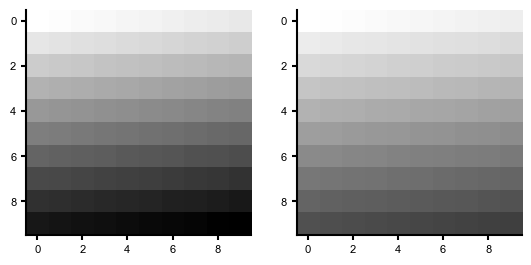

In [14]:
# FROM: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_yarg')
new_cmap = truncate_colormap(cmap, 0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

[ 1.8024843 -0.6009391] 1.2450836 0.5235579 161.56725
[ 1.8024843 -0.6009391] 2.4901671 1.0471158 161.56725
[ 1.8024843 -0.6009391] 4.9803343 2.0942316 161.56725
[ 1.8024843 -0.6009391] 9.960669 4.188463 161.56725
[ 2.9873376 -0.9998031] 0.62564033 0.5742745 174.65733
[ 2.9873376 -0.9998031] 1.2512807 1.148549 174.65733
[ 2.9873376 -0.9998031] 2.5025613 2.297098 174.65733
[ 2.9873376 -0.9998031] 5.0051227 4.594196 174.65733
[ 2.318416   -0.78114593] 1.0562881 0.49855614 161.7324
[ 2.318416   -0.78114593] 2.1125762 0.9971123 161.7324
[ 2.318416   -0.78114593] 4.2251525 1.9942245 161.7324
[ 2.318416   -0.78114593] 8.450305 3.988449 161.7324


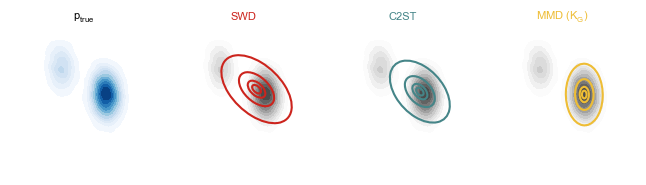

In [15]:
num_samples = 10000
#SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
#MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
#C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
#SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
#MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
#C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,4, figsize = (6.5,3))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)

alpha_bg=1
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[3],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)

#x, y = np.mgrid[-10:10:.1, -10:10:.1]
#z =torch.exp(gauss_model_WS.log_prob(data)).detach().numpy()
##axs[1].contour(x, y, z,colors ='#cc241d')#), cmap='coolwarm',fill=False)
##z =torch.exp(gauss_model_MMD.log_prob(data)).detach().numpy()
#axs[2].contour(x, y, z,colors ='#eebd35')#), cmap='coolwarm',fill=False)
#z =torch.exp(gauss_model_C2ST.log_prob(data)).detach().numpy()
#axs[3].contour(x, y, z,colors ="#458588")#), cmap='coolwarm',fill=False)
std_plot = [np.sqrt(.25),np.sqrt(.5),np.sqrt(1),np.sqrt(2)]
std_plot=[.25,.5,1,2]
plot_cov_ellipse(gauss_model_WS.cov().detach().numpy(),gauss_model_WS.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
#axs[1].scatter(gauss_model_WS.mean.detach().numpy()[0],gauss_model_WS.mean.detach().numpy()[1],
#               color='#cc241d',s=1.5)
plot_cov_ellipse(gauss_model_MMD.cov().detach().numpy(),gauss_model_MMD.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(gauss_model_C2ST.cov().detach().numpy(),gauss_model_C2ST.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')

#sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[3],data=C2ST_df, x='x', y='y', fill=False,cmap='Blues',levels=7)#color="#eebd35",alpha=.5, levels=5)
#color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_xlim(-10,10)

    ax.set_ylim(-7,4)
    #make square subplots 
    ax.set_box_aspect(1)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SWD",color ='#cc241d')
axs[3].set_title("MMD " +r"($K_G$)",color ='#eebd35')
axs[2].set_title("C2ST",color ="#458588")

fig.tight_layout()
plt.savefig("mode.pdf")

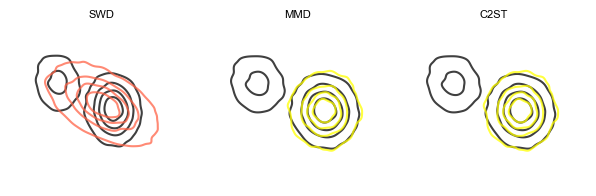

In [16]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
